In [25]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCHDYNAMO_VERBOSE'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights, fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models import MobileNet_V3_Large_Weights, ResNet50_Weights
from torchvision.models.detection.rpn import concat_box_prediction_layers
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision import ops as tv_ops

import numpy as np
import random
import math
from pathlib import Path
from fastai.vision import *
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import RichProgressBar, ModelCheckpoint, EarlyStopping, LearningRateMonitor, RichModelSummary
import cv2
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils
from PIL import  Image
from matplotlib import pyplot as plt
import logging
import sys
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)
torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
# logger.setLevel(logging.DEBUG)

In [2]:
ROOT_DIR = Path("/home/vamsik1211/Data/git-repos/ClearquoteProject/exercise-2/dataset/train")
coco_annotations = {}
for image_dir in ROOT_DIR.iterdir():
    if image_dir.is_dir():
        coco_data = coco.COCO(image_dir / "coco_data.json")
        coco_annotations[image_dir.name] = coco_data

# Test Data
ROOT_DIR_TEST = Path("/home/vamsik1211/Data/git-repos/ClearquoteProject/exercise-2/dataset/test")
coco_annotations_test = {}
for image_dir in ROOT_DIR_TEST.iterdir():
    if image_dir.is_dir():
        coco_data = coco.COCO(image_dir / "coco_data.json")
        coco_annotations_test[image_dir.name] = coco_data

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load

In [3]:
class LoadData(Dataset):
    def __init__(self, root_dir: Path, coco_annotations: dict[str, coco.COCO], transform=None, device="cpu"):
        self.root_dir = root_dir
        self.coco_annotations = coco_annotations
        self.transform = transform
        self.device = device

    def load_images_paths(self) -> list[Path]:
        images = []
        for image_dir in self.root_dir.iterdir():
            if image_dir.is_dir():
                images.extend(list(image_dir.glob("**.jpg")))
        return images
    
    def __len__(self):
        # return len(self.images)
        total_len = 0
        for anns in self.coco_annotations.values():
            total_len += len(anns.getImgIds())

        return total_len
    
    def get_idx_coco_section(self, idx: int) -> tuple[str, coco.COCO, int]:
        start_len = 0
        for folder_name, anns in self.coco_annotations.items():
            end_len = start_len + len(anns.getImgIds())
            if idx < end_len:
                return folder_name, anns, idx - start_len + 1
            else:
                start_len = end_len

    def collate_fn(self, batch):
        images = []
        targets = []

        for image, target in batch:
            if target["boxes"].shape[0] == 0:
                continue
            if self.device:
                image = image.to(self.device)
                target["boxes"] = target["boxes"].to(self.device)
                target["labels"] = target["labels"].to(self.device)
            images.append(image)
            targets.append(target)

        images = torch.stack(images)
        return images, targets
            
        
            
    
    def __getitem__(self, idx):
        # print("INDEX", idx)
        folder_name, annotations, image_idx = self.get_idx_coco_section(idx)
        image_attributes = annotations.loadImgs([image_idx])[0]
        image_path = self.root_dir / folder_name / image_attributes["file_name"]
        image = Image.open(image_path).convert("RGB")
        image = np.array(image)

        # print(folder_name, image_idx, image_attributes)


        annotations = self.coco_annotations[image_path.parent.name].loadAnns(self.coco_annotations[image_path.parent.name].getAnnIds(image_idx))
        boxes = []
        labels = []
        for annotation in annotations:
            bbox = [annotation['bbox'][0], annotation['bbox'][1], annotation['bbox'][0] + annotation['bbox'][2], annotation['bbox'][1] + annotation['bbox'][3]]
            boxes.append(bbox)
            labels.append(annotation["category_id"])

        if self.transform:
            transformed_data = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed_data["image"]
            boxes = transformed_data["bboxes"]
            # labels = transformed_data["labels"]
        
        targets = {}
        targets["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        targets["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        
        return (torch.as_tensor(image)).permute(2, 0, 1)/255., targets

In [4]:
transform = A.Compose([
    A.Resize(720, 1280),
    A.ChannelShuffle(p=0.5),
    A.RandomBrightnessContrast(p=0.5, ),
    A.GaussNoise(p=0.5, var_limit=(10.0, 100.0)),
    A.Equalize(p=0.5),
    # A.Normalize(),
    # ToTensorV2()
# ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=['LCD', 'M', 'not_touching', 'odometer', 'screen']))
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=['labels']))

transform_test = A.Compose([
    A.Resize(720, 1280),
    # A.Normalize(),
    # ToTensorV2()
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=['labels']))

INFO:__main__:Using device cuda
3400


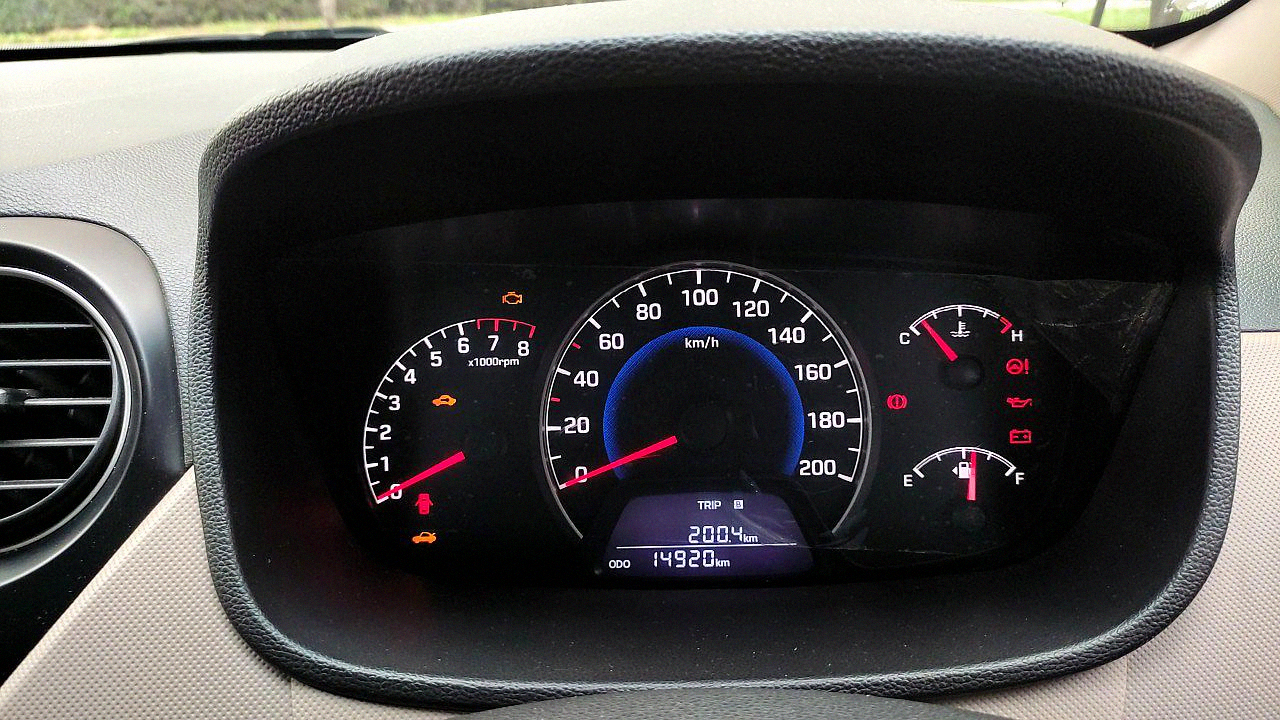

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device {DEVICE}")

odometer_dataset = LoadData(ROOT_DIR, coco_annotations, transform=transform)
odometer_dataset_test = LoadData(ROOT_DIR_TEST, coco_annotations_test, transform=transform_test)
print(len(odometer_dataset))
ret_data = odometer_dataset[80]

Image.fromarray((ret_data[0].permute(1, 2, 0).numpy()*255).astype(np.uint8))

In [6]:
(ret_data[0].permute(1, 2, 0).numpy()*255).astype(np.uint8).min()

0

In [7]:
(ret_data[0].permute(1, 2, 0).numpy()*255).shape

(720, 1280, 3)

In [8]:
ret_data[1]["boxes"].shape

torch.Size([2, 4])

In [9]:
odometer_dataloader = DataLoader(odometer_dataset, batch_size=2, shuffle=True, collate_fn=odometer_dataset.collate_fn)


In [10]:
for batch in odometer_dataloader:
    print(batch[0].shape)
    # print(batch[1])
    break

torch.Size([2, 3, 720, 1280])


In [11]:
targets = batch[1]

for target in targets:
    boxes = target["boxes"]
    labels = target["labels"]
    logger.debug(boxes)

In [12]:
# batch[1]["labels"].shape
print(__name__)

__main__


In [13]:
# image_np = np.asarray(ret_data[0])

# for targets in ret_data[1]:
#     bboxes = targets["boxes"]
#     cv2.rectangle(image_np, (bboxes[0], bboxes[1]), (bboxes[0] + bboxes[2], bboxes[1] + bboxes[3]), (255, 0, 0), 2)
#     # mask = annotations.annToMask(ann)
#     # mask = np.dstack([mask] * 3)*128
#     # image = cv2.addWeighted(image, 0.5, mask, 0.5, 0, image)

# plt.imshow(image_np)

In [14]:
MAX_EPOCHS = 20
MIN_EPOCHS = 10

# LEARNING_RATES = {
#     "rpn": 0.005,
#     "roi_heads": 0.01,
#     "backbone_body": 0.0001,
#     "backbone_fpn": 0.005,
# }

LEARNING_RATES = {
    "rpn": 9.93e-4,
    "roi_heads": 0.001987,
    "backbone_body": 1.99e-5,
    "backbone_fpn": 0.00107,
}

BATCH_SIZE = 8
STEPS_PER_EPOCH = len(odometer_dataset)/BATCH_SIZE
if type(STEPS_PER_EPOCH) == float:
    STEPS_PER_EPOCH = math.ceil(STEPS_PER_EPOCH)


In [15]:
STEPS_PER_EPOCH

425

In [16]:
torch._dynamo.list_backends()

['cudagraphs', 'inductor', 'onnxrt', 'openxla', 'openxla_eval', 'tvm']

In [17]:
# fasterrcnn_model = fasterrcnn_mobilenet_v3_large_fpn(num_classes=3, trainable_backbone_layers=6, weights_backbone=MobileNet_V3_Large_Weights.DEFAULT).to(DEVICE)
fasterrcnn_model = fasterrcnn_resnet50_fpn_v2(num_classes=3, trainable_backbone_layers=5, weights_backbone=ResNet50_Weights.DEFAULT).to(DEVICE)
fasterrcnn_model.transform._skip_resize = True
# fasterrcnn_model = torch.compile(fasterrcnn_model)

In [18]:
# fasterrcnn_model

In [19]:
9.93e-4

0.000993

In [20]:
from typing import Any, Optional, OrderedDict, List, Tuple, Union, Dict


from lightning.pytorch.utilities.types import LRSchedulerTypeUnion


class FasterRCNN(L.LightningModule):
    def __init__(self, model: nn.Module, lr: float = 1e-3, batch_size: int = 16):
        super().__init__()
        self.model = model
        self.lr = lr
        self.batch_size = batch_size

        self.automatic_optimization = False

    def eval_forward(self, model, images, targets):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        """
        Args:
            images (list[Tensor]): images to be processed
            targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                It returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).
        """
        model.eval()

        original_image_sizes: List[Tuple[int, int]] = []
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        images, targets = model.transform(images, targets)

        # Check for degenerate boxes
        # TODO: Move this to a function
        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenerate box
                    bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    raise ValueError(
                        "All bounding boxes should have positive height and width."
                        f" Found invalid box {degen_bb} for target at index {target_idx}."
                    )

        features = model.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])
        model.rpn.training=True
        #model.roi_heads.training=True


        #####proposals, proposal_losses = model.rpn(images, features, targets)
        features_rpn = list(features.values())
        objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
        anchors = model.rpn.anchor_generator(images, features_rpn)

        num_images = len(anchors)
        num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
        num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
        objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
        # apply pred_bbox_deltas to anchors to obtain the decoded proposals
        # note that we detach the deltas because Faster R-CNN do not backprop through
        # the proposals
        proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
        proposals = proposals.view(num_images, -1, 4)
        proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

        proposal_losses = {}
        assert targets is not None
        labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
        regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
        loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
            objectness, pred_bbox_deltas, labels, regression_targets
        )
        proposal_losses = {
            "loss_objectness": loss_objectness,
            "loss_rpn_box_reg": loss_rpn_box_reg,
        }

        #####detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
        image_shapes = images.image_sizes
        proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
        box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
        box_features = model.roi_heads.box_head(box_features)
        class_logits, box_regression = model.roi_heads.box_predictor(box_features)

        result: List[Dict[str, torch.Tensor]] = []
        detector_losses = {}
        loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
        detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
        boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
        num_images = len(boxes)
        for i in range(num_images):
            result.append(
                {
                    "boxes": boxes[i],
                    "labels": labels[i],
                    "scores": scores[i],
                }
            )
        detections = result
        detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
        model.rpn.training=False
        model.roi_heads.training=False
        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)
        return losses, detections


    def training_step(self, batch, batch_idx):
        
        optimizer_backbone_body, optimizer_backbone_fpn, optimizer_rpn, optimizer_roi_heads = self.optimizers()

        image, targets = batch
        loss_dict = self.model(image, targets)
        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()
        if not math.isfinite(loss_value):
            logger.debug(f"Loss is {loss_value}, stopping training")
            sys.exit(1)

        self.log("train_loss", losses, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=image.shape[0])

        for loss_name, loss_value in loss_dict.items():
            self.log(f"train_loss_{loss_name}", loss_value.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=image.shape[0])

        optimizer_backbone_body.zero_grad()
        optimizer_backbone_fpn.zero_grad()
        optimizer_rpn.zero_grad()
        optimizer_roi_heads.zero_grad()

        self.manual_backward(losses)
        
        optimizer_backbone_body.step()
        optimizer_backbone_fpn.step()
        optimizer_rpn.step()
        optimizer_roi_heads.step()

        lr_scheduler_backbone_body, lr_scheduler_backbone_fpn, lr_scheduler_rpn, lr_scheduler_roi_heads = self.lr_schedulers()

        lr_scheduler_backbone_body.step()
        lr_scheduler_backbone_fpn.step()
        lr_scheduler_rpn.step()
        lr_scheduler_roi_heads.step()

        # momentum_backbone_body = optimizer_backbone_body.param_groups[0]['momentum']
        # momentum_backbone_fpn = optimizer_backbone_fpn.param_groups[0]['momentum']
        # momentum_rpn = optimizer_rpn.param_groups[0]['momentum']
        # momentum_roi_heads = optimizer_roi_heads.param_groups[0]['momentum']

        # self.log("momentum_backbone_body", momentum_backbone_body, on_step=True, logger=True, on_epoch=False)
        # self.log("momentum_backbone_fpn", momentum_backbone_fpn, on_step=True, logger=True, on_epoch=False)
        # self.log("momentum_rpn", momentum_rpn, on_step=True, logger=True, on_epoch=False)
        # self.log("momentum_roi_heads", momentum_roi_heads, on_step=True, logger=True, on_epoch=False)

        return losses
    
    def validation_step(self, batch, batch_idx):
        image, targets = batch

        loss_dict, detections = self.eval_forward(self.model, image, targets)

        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()
        if not math.isfinite(loss_value):
            logger.debug(f"Loss is {loss_value}, stopping training")
            sys.exit(1)

        self.log("val_loss", losses, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=image.shape[0])

        for loss_name, loss_value in loss_dict.items():
            self.log(f"val_loss_{loss_name}", loss_value.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=image.shape[0])

        # Calculate mAP
        # detections = self.model.transform.postprocess(detections, image.image_sizes, image.image_sizes)  # type: ignore[operator]
        # detections = self.model.transform.batched_unpadding(detections, image.image_sizes)
        # detections = self.model.transform.batched_nms(detections, 0.5)


        return losses
    
    def lr_scheduler_step(self, scheduler: LRSchedulerTypeUnion, metric: Optional[Any]) -> None:

        # lr_scheduler_backbone, lr_scheduler_rpn, lr_scheduler_roi_heads = self.lr_schedulers()

        # lr_scheduler_backbone.step()
        # lr_scheduler_rpn.step()
        # lr_scheduler_roi_heads.step()

        pass

    def configure_optimizers(self):

        # optimizer_backbone = optim.Adam(self.model.backbone.parameters(), lr=self.lr)
        # optimizer_rpn = optim.Adam(self.model.rpn.parameters(), lr=self.lr)
        # optimizer_roi_heads = optim.Adam(self.model.roi_heads.parameters(), lr=self.lr)

        optimizer_backbone_body = optim.SGD(self.model.backbone.body.parameters(), lr=LEARNING_RATES["backbone_body"], momentum=0.9, weight_decay=0.0005)
        optimizer_backbone_fpn = optim.SGD(self.model.backbone.fpn.parameters(), lr=LEARNING_RATES["backbone_fpn"], momentum=0.9, weight_decay=0.0001)
        optimizer_rpn = optim.SGD(self.model.rpn.parameters(), lr=LEARNING_RATES["rpn"], momentum=0.9, weight_decay=0.0001)
        optimizer_roi_heads = optim.SGD(self.model.roi_heads.parameters(), lr=LEARNING_RATES["roi_heads"], momentum=0.9, weight_decay=0.0001)

        # optimizer_backbone_body = optim.Adam(self.model.backbone.body.parameters(), lr=LEARNING_RATES["backbone_body"], betas=(0.8, 0.999), weight_decay=0.0005)
        # optimizer_backbone_fpn = optim.Adam(self.model.backbone.fpn.parameters(), lr=LEARNING_RATES["backbone_fpn"], betas=(0.8, 0.999), weight_decay=0.0001)
        # optimizer_rpn = optim.Adam(self.model.rpn.parameters(), lr=LEARNING_RATES["rpn"], betas=(0.8, 0.999), weight_decay=0.0001)
        # optimizer_roi_heads = optim.Adam(self.model.roi_heads.parameters(), lr=LEARNING_RATES["roi_heads"], betas=(0.8, 0.999), weight_decay=0.0001)

        lr_scheduler_backbone_body = optim.lr_scheduler.OneCycleLR(optimizer_backbone_body, max_lr=LEARNING_RATES["backbone_body"], pct_start=0.0, base_momentum=0.75, max_momentum=0.95, epochs=MAX_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)
        lr_scheduler_backbone_body = {
            "scheduler": lr_scheduler_backbone_body,
            "interval": "step",
            "name": "lr_scheduler_backbone_body",
            # "frequency": 1
        }

        lr_scheduler_backbone_fpn = optim.lr_scheduler.OneCycleLR(optimizer_backbone_fpn, max_lr=LEARNING_RATES["backbone_fpn"], pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, epochs=MAX_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)
        lr_scheduler_backbone_fpn = {
            "scheduler": lr_scheduler_backbone_fpn,
            "interval": "step",
            "name": "lr_scheduler_backbone_fpn",
        }

        lr_scheduler_rpn = optim.lr_scheduler.OneCycleLR(optimizer_rpn, max_lr=LEARNING_RATES["rpn"], pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, epochs=MAX_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)
        lr_scheduler_rpn = {
            "scheduler": lr_scheduler_rpn,
            "interval": "step",
            "name": "lr_scheduler_rpn",
            # "frequency": 1
        }


        lr_scheduler_roi_heads = optim.lr_scheduler.OneCycleLR(optimizer_roi_heads, max_lr=LEARNING_RATES["roi_heads"], pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, epochs=MAX_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)
        lr_scheduler_roi_heads = {
            "scheduler": lr_scheduler_roi_heads,
            "interval": "step",
            "name": "lr_scheduler_roi_heads",
            # "frequency": 1
        }

        return [optimizer_backbone_body, optimizer_backbone_fpn, optimizer_rpn, optimizer_roi_heads], [lr_scheduler_backbone_body, lr_scheduler_backbone_fpn, lr_scheduler_rpn, lr_scheduler_roi_heads]

        return optim.Adam(self.parameters(), lr=self.lr)
        # return (
        #     {
        #         "optimizer": optimizer_backbone,
        #         "lr_scheduler": lr_scheduler_backbone
        #     },
        #     {
        #         "optimizer": optimizer_rpn,
        #         "lr_scheduler": lr_scheduler_rpn
        #     },
        #     {
        #         "optimizer": optimizer_roi_heads,
        #         "lr_scheduler": lr_scheduler_roi_heads
        #     }
        # )

    def train_dataloader(self):
        return DataLoader(odometer_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=odometer_dataset.collate_fn, num_workers=10, pin_memory=True, drop_last=False)
    
    def val_dataloader(self):
        return DataLoader(odometer_dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=odometer_dataset_test.collate_fn, num_workers=10, pin_memory=True, drop_last=False)
    


In [105]:
model = FasterRCNN(fasterrcnn_model, lr=0.1)
model.load_state_dict(torch.load("tb_logs/fasterrcnn_v2/version_9/checkpoints/fasterrcnn-mobilenet-epoch=15-val_loss=0.11.ckpt")["state_dict"])
# model = FasterRCNN.load_from_checkpoint("tb_logs/fasterrcnn_v2/version_8/checkpoints/fasterrcnn-mobilenet-epoch=09-val_loss=0.11.ckpt")


callbacks = [
    RichProgressBar(), 
    LearningRateMonitor(
        logging_interval="step",
    ),
    RichModelSummary(max_depth=2),
    ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        filename="fasterrcnn-mobilenet-{epoch:02d}-{val_loss:.2f}",
        save_top_k=3,
        # dirpath="checkpoints",
    ),
]
tb_logger = TensorBoardLogger("tb_logs", name="fasterrcnn_v2")

trainer = L.Trainer(
    accelerator="gpu", 
    max_epochs=MAX_EPOCHS,
    callbacks=callbacks,
    logger=tb_logger,
    precision=32,

    min_epochs=MIN_EPOCHS,
    enable_checkpointing=True
    )


Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name            ┃ Type                     ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model           │ FasterRCNN               │ 43.3 M │
│ 1 │ model.transform │ GeneralizedRCNNTransform │      0 │
│ 2 │ model.backbone  │ BackboneWithFPN          │ 26.9 M │
│ 3 │ model.rpn       │ RegionProposalNetwork    │  1.2 M │
│ 4 │ model.roi_heads │ RoIHeads                 │ 15.2 M │
└───┴─────────────────┴──────────────────────────┴────────┘

Trainable params: 43.3 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 43.3 M                                                                                               
Total estimated model params size (MB): 173

Output()

In [106]:
fasterrcnn_model_extracted = model.model

In [112]:
odometer_dataloader_test = DataLoader(odometer_dataset_test, batch_size=16, shuffle=True, collate_fn=odometer_dataset.collate_fn)


for batch in odometer_dataloader_test:
    print(batch[0].shape)
    # print(batch[1])
    break
with torch.no_grad():
    fasterrcnn_model_extracted.eval().to(DEVICE)
    data = fasterrcnn_model_extracted(batch[0].to(DEVICE))

    print(data)

torch.Size([16, 3, 720, 1280])
[{'boxes': tensor([[607.5632, 503.9354, 771.0975, 587.0860],
        [619.1299, 512.5207, 735.2205, 548.9089],
        [630.7964, 514.1724, 677.0859, 549.5068],
        [468.7012, 329.4056, 597.0377, 505.3196],
        [619.5861, 505.0875, 753.8345, 551.4829],
        [514.3794, 489.7722, 815.9848, 599.9153],
        [653.1069, 514.2097, 731.3765, 538.7627]], device='cuda:0'), 'labels': tensor([1, 2, 2, 1, 1, 1, 2], device='cuda:0'), 'scores': tensor([0.9980, 0.9916, 0.2743, 0.1389, 0.1171, 0.0979, 0.0935],
       device='cuda:0')}, {'boxes': tensor([[ 870.2385,  330.1501, 1037.8521,  408.8205],
        [ 919.5249,  370.5267, 1006.9295,  398.2671],
        [ 854.3643,  268.5471, 1062.0181,  433.5565],
        [ 921.6450,  370.6440,  959.6740,  397.8987],
        [ 900.4548,  339.0522, 1022.5820,  380.6053]], device='cuda:0'), 'labels': tensor([1, 2, 1, 2, 1], device='cuda:0'), 'scores': tensor([0.9993, 0.9986, 0.0786, 0.0682, 0.0509], device='cuda:0')}, {

In [149]:
torch.save(fasterrcnn_model_extracted.state_dict(), "weights/fasterrcnn/fasterrcnn-resnet50.pt")

In [145]:
INDEX = 8
CATEGORY = 2

nms_indexes = tv_ops.batched_nms(data[INDEX]["boxes"], data[INDEX]["scores"], data[INDEX]["labels"], 0.2)

bboxes = torch.index_select(input=data[INDEX]["boxes"], index=nms_indexes, dim=0)
labels = torch.index_select(input=data[INDEX]["labels"], index=nms_indexes, dim=0)
scores = torch.index_select(input=data[INDEX]["scores"], index=nms_indexes, dim=0)

bboxes = torch.index_select(bboxes, index=torch.where(labels == CATEGORY)[0], dim=0)
labels = torch.index_select(labels, index=torch.where(labels == CATEGORY)[0], dim=0)
scores = torch.index_select(scores, index=torch.where(labels == CATEGORY)[0], dim=0)

bboxes = torch.index_select(bboxes, index=torch.where(scores > 0.5)[0], dim=0)
labels = torch.index_select(labels, index=torch.where(scores > 0.5)[0], dim=0)
scores = torch.index_select(scores, index=torch.where(scores > 0.5)[0], dim=0)


# odometer_bboxes = torch.take(data[0]["boxes"], torch.where(data[0]["labels"] == 1)[0], )
# odometer_bboxes

In [150]:
nms_indexes

tensor([0, 1], device='cuda:0')

: 

In [94]:
labels.shape

torch.Size([9])

In [78]:
torch.where(data[1]["scores"] >= 0.7)[0].shape

torch.Size([2])

In [ ]:
state_dict = torch.load("tb_logs/fasterrcnn/version_11/checkpoints/fasterrcnn-mobilenet-epoch=13-val_loss=0.16.ckpt")

In [ ]:
model.load_state_dict(state_dict["state_dict"])

RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	Missing key(s) in state_dict: "model.backbone.body.conv1.weight", "model.backbone.body.bn1.weight", "model.backbone.body.bn1.bias", "model.backbone.body.bn1.running_mean", "model.backbone.body.bn1.running_var", "model.backbone.body.layer1.0.conv1.weight", "model.backbone.body.layer1.0.bn1.weight", "model.backbone.body.layer1.0.bn1.bias", "model.backbone.body.layer1.0.bn1.running_mean", "model.backbone.body.layer1.0.bn1.running_var", "model.backbone.body.layer1.0.conv2.weight", "model.backbone.body.layer1.0.bn2.weight", "model.backbone.body.layer1.0.bn2.bias", "model.backbone.body.layer1.0.bn2.running_mean", "model.backbone.body.layer1.0.bn2.running_var", "model.backbone.body.layer1.0.conv3.weight", "model.backbone.body.layer1.0.bn3.weight", "model.backbone.body.layer1.0.bn3.bias", "model.backbone.body.layer1.0.bn3.running_mean", "model.backbone.body.layer1.0.bn3.running_var", "model.backbone.body.layer1.0.downsample.0.weight", "model.backbone.body.layer1.0.downsample.1.weight", "model.backbone.body.layer1.0.downsample.1.bias", "model.backbone.body.layer1.0.downsample.1.running_mean", "model.backbone.body.layer1.0.downsample.1.running_var", "model.backbone.body.layer1.1.conv1.weight", "model.backbone.body.layer1.1.bn1.weight", "model.backbone.body.layer1.1.bn1.bias", "model.backbone.body.layer1.1.bn1.running_mean", "model.backbone.body.layer1.1.bn1.running_var", "model.backbone.body.layer1.1.conv2.weight", "model.backbone.body.layer1.1.bn2.weight", "model.backbone.body.layer1.1.bn2.bias", "model.backbone.body.layer1.1.bn2.running_mean", "model.backbone.body.layer1.1.bn2.running_var", "model.backbone.body.layer1.1.conv3.weight", "model.backbone.body.layer1.1.bn3.weight", "model.backbone.body.layer1.1.bn3.bias", "model.backbone.body.layer1.1.bn3.running_mean", "model.backbone.body.layer1.1.bn3.running_var", "model.backbone.body.layer1.2.conv1.weight", "model.backbone.body.layer1.2.bn1.weight", "model.backbone.body.layer1.2.bn1.bias", "model.backbone.body.layer1.2.bn1.running_mean", "model.backbone.body.layer1.2.bn1.running_var", "model.backbone.body.layer1.2.conv2.weight", "model.backbone.body.layer1.2.bn2.weight", "model.backbone.body.layer1.2.bn2.bias", "model.backbone.body.layer1.2.bn2.running_mean", "model.backbone.body.layer1.2.bn2.running_var", "model.backbone.body.layer1.2.conv3.weight", "model.backbone.body.layer1.2.bn3.weight", "model.backbone.body.layer1.2.bn3.bias", "model.backbone.body.layer1.2.bn3.running_mean", "model.backbone.body.layer1.2.bn3.running_var", "model.backbone.body.layer2.0.conv1.weight", "model.backbone.body.layer2.0.bn1.weight", "model.backbone.body.layer2.0.bn1.bias", "model.backbone.body.layer2.0.bn1.running_mean", "model.backbone.body.layer2.0.bn1.running_var", "model.backbone.body.layer2.0.conv2.weight", "model.backbone.body.layer2.0.bn2.weight", "model.backbone.body.layer2.0.bn2.bias", "model.backbone.body.layer2.0.bn2.running_mean", "model.backbone.body.layer2.0.bn2.running_var", "model.backbone.body.layer2.0.conv3.weight", "model.backbone.body.layer2.0.bn3.weight", "model.backbone.body.layer2.0.bn3.bias", "model.backbone.body.layer2.0.bn3.running_mean", "model.backbone.body.layer2.0.bn3.running_var", "model.backbone.body.layer2.0.downsample.0.weight", "model.backbone.body.layer2.0.downsample.1.weight", "model.backbone.body.layer2.0.downsample.1.bias", "model.backbone.body.layer2.0.downsample.1.running_mean", "model.backbone.body.layer2.0.downsample.1.running_var", "model.backbone.body.layer2.1.conv1.weight", "model.backbone.body.layer2.1.bn1.weight", "model.backbone.body.layer2.1.bn1.bias", "model.backbone.body.layer2.1.bn1.running_mean", "model.backbone.body.layer2.1.bn1.running_var", "model.backbone.body.layer2.1.conv2.weight", "model.backbone.body.layer2.1.bn2.weight", "model.backbone.body.layer2.1.bn2.bias", "model.backbone.body.layer2.1.bn2.running_mean", "model.backbone.body.layer2.1.bn2.running_var", "model.backbone.body.layer2.1.conv3.weight", "model.backbone.body.layer2.1.bn3.weight", "model.backbone.body.layer2.1.bn3.bias", "model.backbone.body.layer2.1.bn3.running_mean", "model.backbone.body.layer2.1.bn3.running_var", "model.backbone.body.layer2.2.conv1.weight", "model.backbone.body.layer2.2.bn1.weight", "model.backbone.body.layer2.2.bn1.bias", "model.backbone.body.layer2.2.bn1.running_mean", "model.backbone.body.layer2.2.bn1.running_var", "model.backbone.body.layer2.2.conv2.weight", "model.backbone.body.layer2.2.bn2.weight", "model.backbone.body.layer2.2.bn2.bias", "model.backbone.body.layer2.2.bn2.running_mean", "model.backbone.body.layer2.2.bn2.running_var", "model.backbone.body.layer2.2.conv3.weight", "model.backbone.body.layer2.2.bn3.weight", "model.backbone.body.layer2.2.bn3.bias", "model.backbone.body.layer2.2.bn3.running_mean", "model.backbone.body.layer2.2.bn3.running_var", "model.backbone.body.layer2.3.conv1.weight", "model.backbone.body.layer2.3.bn1.weight", "model.backbone.body.layer2.3.bn1.bias", "model.backbone.body.layer2.3.bn1.running_mean", "model.backbone.body.layer2.3.bn1.running_var", "model.backbone.body.layer2.3.conv2.weight", "model.backbone.body.layer2.3.bn2.weight", "model.backbone.body.layer2.3.bn2.bias", "model.backbone.body.layer2.3.bn2.running_mean", "model.backbone.body.layer2.3.bn2.running_var", "model.backbone.body.layer2.3.conv3.weight", "model.backbone.body.layer2.3.bn3.weight", "model.backbone.body.layer2.3.bn3.bias", "model.backbone.body.layer2.3.bn3.running_mean", "model.backbone.body.layer2.3.bn3.running_var", "model.backbone.body.layer3.0.conv1.weight", "model.backbone.body.layer3.0.bn1.weight", "model.backbone.body.layer3.0.bn1.bias", "model.backbone.body.layer3.0.bn1.running_mean", "model.backbone.body.layer3.0.bn1.running_var", "model.backbone.body.layer3.0.conv2.weight", "model.backbone.body.layer3.0.bn2.weight", "model.backbone.body.layer3.0.bn2.bias", "model.backbone.body.layer3.0.bn2.running_mean", "model.backbone.body.layer3.0.bn2.running_var", "model.backbone.body.layer3.0.conv3.weight", "model.backbone.body.layer3.0.bn3.weight", "model.backbone.body.layer3.0.bn3.bias", "model.backbone.body.layer3.0.bn3.running_mean", "model.backbone.body.layer3.0.bn3.running_var", "model.backbone.body.layer3.0.downsample.0.weight", "model.backbone.body.layer3.0.downsample.1.weight", "model.backbone.body.layer3.0.downsample.1.bias", "model.backbone.body.layer3.0.downsample.1.running_mean", "model.backbone.body.layer3.0.downsample.1.running_var", "model.backbone.body.layer3.1.conv1.weight", "model.backbone.body.layer3.1.bn1.weight", "model.backbone.body.layer3.1.bn1.bias", "model.backbone.body.layer3.1.bn1.running_mean", "model.backbone.body.layer3.1.bn1.running_var", "model.backbone.body.layer3.1.conv2.weight", "model.backbone.body.layer3.1.bn2.weight", "model.backbone.body.layer3.1.bn2.bias", "model.backbone.body.layer3.1.bn2.running_mean", "model.backbone.body.layer3.1.bn2.running_var", "model.backbone.body.layer3.1.conv3.weight", "model.backbone.body.layer3.1.bn3.weight", "model.backbone.body.layer3.1.bn3.bias", "model.backbone.body.layer3.1.bn3.running_mean", "model.backbone.body.layer3.1.bn3.running_var", "model.backbone.body.layer3.2.conv1.weight", "model.backbone.body.layer3.2.bn1.weight", "model.backbone.body.layer3.2.bn1.bias", "model.backbone.body.layer3.2.bn1.running_mean", "model.backbone.body.layer3.2.bn1.running_var", "model.backbone.body.layer3.2.conv2.weight", "model.backbone.body.layer3.2.bn2.weight", "model.backbone.body.layer3.2.bn2.bias", "model.backbone.body.layer3.2.bn2.running_mean", "model.backbone.body.layer3.2.bn2.running_var", "model.backbone.body.layer3.2.conv3.weight", "model.backbone.body.layer3.2.bn3.weight", "model.backbone.body.layer3.2.bn3.bias", "model.backbone.body.layer3.2.bn3.running_mean", "model.backbone.body.layer3.2.bn3.running_var", "model.backbone.body.layer3.3.conv1.weight", "model.backbone.body.layer3.3.bn1.weight", "model.backbone.body.layer3.3.bn1.bias", "model.backbone.body.layer3.3.bn1.running_mean", "model.backbone.body.layer3.3.bn1.running_var", "model.backbone.body.layer3.3.conv2.weight", "model.backbone.body.layer3.3.bn2.weight", "model.backbone.body.layer3.3.bn2.bias", "model.backbone.body.layer3.3.bn2.running_mean", "model.backbone.body.layer3.3.bn2.running_var", "model.backbone.body.layer3.3.conv3.weight", "model.backbone.body.layer3.3.bn3.weight", "model.backbone.body.layer3.3.bn3.bias", "model.backbone.body.layer3.3.bn3.running_mean", "model.backbone.body.layer3.3.bn3.running_var", "model.backbone.body.layer3.4.conv1.weight", "model.backbone.body.layer3.4.bn1.weight", "model.backbone.body.layer3.4.bn1.bias", "model.backbone.body.layer3.4.bn1.running_mean", "model.backbone.body.layer3.4.bn1.running_var", "model.backbone.body.layer3.4.conv2.weight", "model.backbone.body.layer3.4.bn2.weight", "model.backbone.body.layer3.4.bn2.bias", "model.backbone.body.layer3.4.bn2.running_mean", "model.backbone.body.layer3.4.bn2.running_var", "model.backbone.body.layer3.4.conv3.weight", "model.backbone.body.layer3.4.bn3.weight", "model.backbone.body.layer3.4.bn3.bias", "model.backbone.body.layer3.4.bn3.running_mean", "model.backbone.body.layer3.4.bn3.running_var", "model.backbone.body.layer3.5.conv1.weight", "model.backbone.body.layer3.5.bn1.weight", "model.backbone.body.layer3.5.bn1.bias", "model.backbone.body.layer3.5.bn1.running_mean", "model.backbone.body.layer3.5.bn1.running_var", "model.backbone.body.layer3.5.conv2.weight", "model.backbone.body.layer3.5.bn2.weight", "model.backbone.body.layer3.5.bn2.bias", "model.backbone.body.layer3.5.bn2.running_mean", "model.backbone.body.layer3.5.bn2.running_var", "model.backbone.body.layer3.5.conv3.weight", "model.backbone.body.layer3.5.bn3.weight", "model.backbone.body.layer3.5.bn3.bias", "model.backbone.body.layer3.5.bn3.running_mean", "model.backbone.body.layer3.5.bn3.running_var", "model.backbone.body.layer4.0.conv1.weight", "model.backbone.body.layer4.0.bn1.weight", "model.backbone.body.layer4.0.bn1.bias", "model.backbone.body.layer4.0.bn1.running_mean", "model.backbone.body.layer4.0.bn1.running_var", "model.backbone.body.layer4.0.conv2.weight", "model.backbone.body.layer4.0.bn2.weight", "model.backbone.body.layer4.0.bn2.bias", "model.backbone.body.layer4.0.bn2.running_mean", "model.backbone.body.layer4.0.bn2.running_var", "model.backbone.body.layer4.0.conv3.weight", "model.backbone.body.layer4.0.bn3.weight", "model.backbone.body.layer4.0.bn3.bias", "model.backbone.body.layer4.0.bn3.running_mean", "model.backbone.body.layer4.0.bn3.running_var", "model.backbone.body.layer4.0.downsample.0.weight", "model.backbone.body.layer4.0.downsample.1.weight", "model.backbone.body.layer4.0.downsample.1.bias", "model.backbone.body.layer4.0.downsample.1.running_mean", "model.backbone.body.layer4.0.downsample.1.running_var", "model.backbone.body.layer4.1.conv1.weight", "model.backbone.body.layer4.1.bn1.weight", "model.backbone.body.layer4.1.bn1.bias", "model.backbone.body.layer4.1.bn1.running_mean", "model.backbone.body.layer4.1.bn1.running_var", "model.backbone.body.layer4.1.conv2.weight", "model.backbone.body.layer4.1.bn2.weight", "model.backbone.body.layer4.1.bn2.bias", "model.backbone.body.layer4.1.bn2.running_mean", "model.backbone.body.layer4.1.bn2.running_var", "model.backbone.body.layer4.1.conv3.weight", "model.backbone.body.layer4.1.bn3.weight", "model.backbone.body.layer4.1.bn3.bias", "model.backbone.body.layer4.1.bn3.running_mean", "model.backbone.body.layer4.1.bn3.running_var", "model.backbone.body.layer4.2.conv1.weight", "model.backbone.body.layer4.2.bn1.weight", "model.backbone.body.layer4.2.bn1.bias", "model.backbone.body.layer4.2.bn1.running_mean", "model.backbone.body.layer4.2.bn1.running_var", "model.backbone.body.layer4.2.conv2.weight", "model.backbone.body.layer4.2.bn2.weight", "model.backbone.body.layer4.2.bn2.bias", "model.backbone.body.layer4.2.bn2.running_mean", "model.backbone.body.layer4.2.bn2.running_var", "model.backbone.body.layer4.2.conv3.weight", "model.backbone.body.layer4.2.bn3.weight", "model.backbone.body.layer4.2.bn3.bias", "model.backbone.body.layer4.2.bn3.running_mean", "model.backbone.body.layer4.2.bn3.running_var", "model.backbone.fpn.inner_blocks.0.1.weight", "model.backbone.fpn.inner_blocks.0.1.bias", "model.backbone.fpn.inner_blocks.0.1.running_mean", "model.backbone.fpn.inner_blocks.0.1.running_var", "model.backbone.fpn.inner_blocks.1.1.weight", "model.backbone.fpn.inner_blocks.1.1.bias", "model.backbone.fpn.inner_blocks.1.1.running_mean", "model.backbone.fpn.inner_blocks.1.1.running_var", "model.backbone.fpn.inner_blocks.2.0.weight", "model.backbone.fpn.inner_blocks.2.1.weight", "model.backbone.fpn.inner_blocks.2.1.bias", "model.backbone.fpn.inner_blocks.2.1.running_mean", "model.backbone.fpn.inner_blocks.2.1.running_var", "model.backbone.fpn.inner_blocks.3.0.weight", "model.backbone.fpn.inner_blocks.3.1.weight", "model.backbone.fpn.inner_blocks.3.1.bias", "model.backbone.fpn.inner_blocks.3.1.running_mean", "model.backbone.fpn.inner_blocks.3.1.running_var", "model.backbone.fpn.layer_blocks.0.1.weight", "model.backbone.fpn.layer_blocks.0.1.bias", "model.backbone.fpn.layer_blocks.0.1.running_mean", "model.backbone.fpn.layer_blocks.0.1.running_var", "model.backbone.fpn.layer_blocks.1.1.weight", "model.backbone.fpn.layer_blocks.1.1.bias", "model.backbone.fpn.layer_blocks.1.1.running_mean", "model.backbone.fpn.layer_blocks.1.1.running_var", "model.backbone.fpn.layer_blocks.2.0.weight", "model.backbone.fpn.layer_blocks.2.1.weight", "model.backbone.fpn.layer_blocks.2.1.bias", "model.backbone.fpn.layer_blocks.2.1.running_mean", "model.backbone.fpn.layer_blocks.2.1.running_var", "model.backbone.fpn.layer_blocks.3.0.weight", "model.backbone.fpn.layer_blocks.3.1.weight", "model.backbone.fpn.layer_blocks.3.1.bias", "model.backbone.fpn.layer_blocks.3.1.running_mean", "model.backbone.fpn.layer_blocks.3.1.running_var", "model.rpn.head.conv.1.0.weight", "model.rpn.head.conv.1.0.bias", "model.roi_heads.box_head.0.0.weight", "model.roi_heads.box_head.0.1.weight", "model.roi_heads.box_head.0.1.bias", "model.roi_heads.box_head.0.1.running_mean", "model.roi_heads.box_head.0.1.running_var", "model.roi_heads.box_head.1.0.weight", "model.roi_heads.box_head.1.1.weight", "model.roi_heads.box_head.1.1.bias", "model.roi_heads.box_head.1.1.running_mean", "model.roi_heads.box_head.1.1.running_var", "model.roi_heads.box_head.2.0.weight", "model.roi_heads.box_head.2.1.weight", "model.roi_heads.box_head.2.1.bias", "model.roi_heads.box_head.2.1.running_mean", "model.roi_heads.box_head.2.1.running_var", "model.roi_heads.box_head.3.0.weight", "model.roi_heads.box_head.3.1.weight", "model.roi_heads.box_head.3.1.bias", "model.roi_heads.box_head.3.1.running_mean", "model.roi_heads.box_head.3.1.running_var", "model.roi_heads.box_head.5.weight", "model.roi_heads.box_head.5.bias". 
	Unexpected key(s) in state_dict: "model.backbone.body.0.0.weight", "model.backbone.body.0.1.weight", "model.backbone.body.0.1.bias", "model.backbone.body.0.1.running_mean", "model.backbone.body.0.1.running_var", "model.backbone.body.1.block.0.0.weight", "model.backbone.body.1.block.0.1.weight", "model.backbone.body.1.block.0.1.bias", "model.backbone.body.1.block.0.1.running_mean", "model.backbone.body.1.block.0.1.running_var", "model.backbone.body.1.block.1.0.weight", "model.backbone.body.1.block.1.1.weight", "model.backbone.body.1.block.1.1.bias", "model.backbone.body.1.block.1.1.running_mean", "model.backbone.body.1.block.1.1.running_var", "model.backbone.body.2.block.0.0.weight", "model.backbone.body.2.block.0.1.weight", "model.backbone.body.2.block.0.1.bias", "model.backbone.body.2.block.0.1.running_mean", "model.backbone.body.2.block.0.1.running_var", "model.backbone.body.2.block.1.0.weight", "model.backbone.body.2.block.1.1.weight", "model.backbone.body.2.block.1.1.bias", "model.backbone.body.2.block.1.1.running_mean", "model.backbone.body.2.block.1.1.running_var", "model.backbone.body.2.block.2.0.weight", "model.backbone.body.2.block.2.1.weight", "model.backbone.body.2.block.2.1.bias", "model.backbone.body.2.block.2.1.running_mean", "model.backbone.body.2.block.2.1.running_var", "model.backbone.body.3.block.0.0.weight", "model.backbone.body.3.block.0.1.weight", "model.backbone.body.3.block.0.1.bias", "model.backbone.body.3.block.0.1.running_mean", "model.backbone.body.3.block.0.1.running_var", "model.backbone.body.3.block.1.0.weight", "model.backbone.body.3.block.1.1.weight", "model.backbone.body.3.block.1.1.bias", "model.backbone.body.3.block.1.1.running_mean", "model.backbone.body.3.block.1.1.running_var", "model.backbone.body.3.block.2.0.weight", "model.backbone.body.3.block.2.1.weight", "model.backbone.body.3.block.2.1.bias", "model.backbone.body.3.block.2.1.running_mean", "model.backbone.body.3.block.2.1.running_var", "model.backbone.body.4.block.0.0.weight", "model.backbone.body.4.block.0.1.weight", "model.backbone.body.4.block.0.1.bias", "model.backbone.body.4.block.0.1.running_mean", "model.backbone.body.4.block.0.1.running_var", "model.backbone.body.4.block.1.0.weight", "model.backbone.body.4.block.1.1.weight", "model.backbone.body.4.block.1.1.bias", "model.backbone.body.4.block.1.1.running_mean", "model.backbone.body.4.block.1.1.running_var", "model.backbone.body.4.block.2.fc1.weight", "model.backbone.body.4.block.2.fc1.bias", "model.backbone.body.4.block.2.fc2.weight", "model.backbone.body.4.block.2.fc2.bias", "model.backbone.body.4.block.3.0.weight", "model.backbone.body.4.block.3.1.weight", "model.backbone.body.4.block.3.1.bias", "model.backbone.body.4.block.3.1.running_mean", "model.backbone.body.4.block.3.1.running_var", "model.backbone.body.5.block.0.0.weight", "model.backbone.body.5.block.0.1.weight", "model.backbone.body.5.block.0.1.bias", "model.backbone.body.5.block.0.1.running_mean", "model.backbone.body.5.block.0.1.running_var", "model.backbone.body.5.block.1.0.weight", "model.backbone.body.5.block.1.1.weight", "model.backbone.body.5.block.1.1.bias", "model.backbone.body.5.block.1.1.running_mean", "model.backbone.body.5.block.1.1.running_var", "model.backbone.body.5.block.2.fc1.weight", "model.backbone.body.5.block.2.fc1.bias", "model.backbone.body.5.block.2.fc2.weight", "model.backbone.body.5.block.2.fc2.bias", "model.backbone.body.5.block.3.0.weight", "model.backbone.body.5.block.3.1.weight", "model.backbone.body.5.block.3.1.bias", "model.backbone.body.5.block.3.1.running_mean", "model.backbone.body.5.block.3.1.running_var", "model.backbone.body.6.block.0.0.weight", "model.backbone.body.6.block.0.1.weight", "model.backbone.body.6.block.0.1.bias", "model.backbone.body.6.block.0.1.running_mean", "model.backbone.body.6.block.0.1.running_var", "model.backbone.body.6.block.1.0.weight", "model.backbone.body.6.block.1.1.weight", "model.backbone.body.6.block.1.1.bias", "model.backbone.body.6.block.1.1.running_mean", "model.backbone.body.6.block.1.1.running_var", "model.backbone.body.6.block.2.fc1.weight", "model.backbone.body.6.block.2.fc1.bias", "model.backbone.body.6.block.2.fc2.weight", "model.backbone.body.6.block.2.fc2.bias", "model.backbone.body.6.block.3.0.weight", "model.backbone.body.6.block.3.1.weight", "model.backbone.body.6.block.3.1.bias", "model.backbone.body.6.block.3.1.running_mean", "model.backbone.body.6.block.3.1.running_var", "model.backbone.body.7.block.0.0.weight", "model.backbone.body.7.block.0.1.weight", "model.backbone.body.7.block.0.1.bias", "model.backbone.body.7.block.0.1.running_mean", "model.backbone.body.7.block.0.1.running_var", "model.backbone.body.7.block.1.0.weight", "model.backbone.body.7.block.1.1.weight", "model.backbone.body.7.block.1.1.bias", "model.backbone.body.7.block.1.1.running_mean", "model.backbone.body.7.block.1.1.running_var", "model.backbone.body.7.block.2.0.weight", "model.backbone.body.7.block.2.1.weight", "model.backbone.body.7.block.2.1.bias", "model.backbone.body.7.block.2.1.running_mean", "model.backbone.body.7.block.2.1.running_var", "model.backbone.body.8.block.0.0.weight", "model.backbone.body.8.block.0.1.weight", "model.backbone.body.8.block.0.1.bias", "model.backbone.body.8.block.0.1.running_mean", "model.backbone.body.8.block.0.1.running_var", "model.backbone.body.8.block.1.0.weight", "model.backbone.body.8.block.1.1.weight", "model.backbone.body.8.block.1.1.bias", "model.backbone.body.8.block.1.1.running_mean", "model.backbone.body.8.block.1.1.running_var", "model.backbone.body.8.block.2.0.weight", "model.backbone.body.8.block.2.1.weight", "model.backbone.body.8.block.2.1.bias", "model.backbone.body.8.block.2.1.running_mean", "model.backbone.body.8.block.2.1.running_var", "model.backbone.body.9.block.0.0.weight", "model.backbone.body.9.block.0.1.weight", "model.backbone.body.9.block.0.1.bias", "model.backbone.body.9.block.0.1.running_mean", "model.backbone.body.9.block.0.1.running_var", "model.backbone.body.9.block.1.0.weight", "model.backbone.body.9.block.1.1.weight", "model.backbone.body.9.block.1.1.bias", "model.backbone.body.9.block.1.1.running_mean", "model.backbone.body.9.block.1.1.running_var", "model.backbone.body.9.block.2.0.weight", "model.backbone.body.9.block.2.1.weight", "model.backbone.body.9.block.2.1.bias", "model.backbone.body.9.block.2.1.running_mean", "model.backbone.body.9.block.2.1.running_var", "model.backbone.body.10.block.0.0.weight", "model.backbone.body.10.block.0.1.weight", "model.backbone.body.10.block.0.1.bias", "model.backbone.body.10.block.0.1.running_mean", "model.backbone.body.10.block.0.1.running_var", "model.backbone.body.10.block.1.0.weight", "model.backbone.body.10.block.1.1.weight", "model.backbone.body.10.block.1.1.bias", "model.backbone.body.10.block.1.1.running_mean", "model.backbone.body.10.block.1.1.running_var", "model.backbone.body.10.block.2.0.weight", "model.backbone.body.10.block.2.1.weight", "model.backbone.body.10.block.2.1.bias", "model.backbone.body.10.block.2.1.running_mean", "model.backbone.body.10.block.2.1.running_var", "model.backbone.body.11.block.0.0.weight", "model.backbone.body.11.block.0.1.weight", "model.backbone.body.11.block.0.1.bias", "model.backbone.body.11.block.0.1.running_mean", "model.backbone.body.11.block.0.1.running_var", "model.backbone.body.11.block.1.0.weight", "model.backbone.body.11.block.1.1.weight", "model.backbone.body.11.block.1.1.bias", "model.backbone.body.11.block.1.1.running_mean", "model.backbone.body.11.block.1.1.running_var", "model.backbone.body.11.block.2.fc1.weight", "model.backbone.body.11.block.2.fc1.bias", "model.backbone.body.11.block.2.fc2.weight", "model.backbone.body.11.block.2.fc2.bias", "model.backbone.body.11.block.3.0.weight", "model.backbone.body.11.block.3.1.weight", "model.backbone.body.11.block.3.1.bias", "model.backbone.body.11.block.3.1.running_mean", "model.backbone.body.11.block.3.1.running_var", "model.backbone.body.12.block.0.0.weight", "model.backbone.body.12.block.0.1.weight", "model.backbone.body.12.block.0.1.bias", "model.backbone.body.12.block.0.1.running_mean", "model.backbone.body.12.block.0.1.running_var", "model.backbone.body.12.block.1.0.weight", "model.backbone.body.12.block.1.1.weight", "model.backbone.body.12.block.1.1.bias", "model.backbone.body.12.block.1.1.running_mean", "model.backbone.body.12.block.1.1.running_var", "model.backbone.body.12.block.2.fc1.weight", "model.backbone.body.12.block.2.fc1.bias", "model.backbone.body.12.block.2.fc2.weight", "model.backbone.body.12.block.2.fc2.bias", "model.backbone.body.12.block.3.0.weight", "model.backbone.body.12.block.3.1.weight", "model.backbone.body.12.block.3.1.bias", "model.backbone.body.12.block.3.1.running_mean", "model.backbone.body.12.block.3.1.running_var", "model.backbone.body.13.block.0.0.weight", "model.backbone.body.13.block.0.1.weight", "model.backbone.body.13.block.0.1.bias", "model.backbone.body.13.block.0.1.running_mean", "model.backbone.body.13.block.0.1.running_var", "model.backbone.body.13.block.1.0.weight", "model.backbone.body.13.block.1.1.weight", "model.backbone.body.13.block.1.1.bias", "model.backbone.body.13.block.1.1.running_mean", "model.backbone.body.13.block.1.1.running_var", "model.backbone.body.13.block.2.fc1.weight", "model.backbone.body.13.block.2.fc1.bias", "model.backbone.body.13.block.2.fc2.weight", "model.backbone.body.13.block.2.fc2.bias", "model.backbone.body.13.block.3.0.weight", "model.backbone.body.13.block.3.1.weight", "model.backbone.body.13.block.3.1.bias", "model.backbone.body.13.block.3.1.running_mean", "model.backbone.body.13.block.3.1.running_var", "model.backbone.body.14.block.0.0.weight", "model.backbone.body.14.block.0.1.weight", "model.backbone.body.14.block.0.1.bias", "model.backbone.body.14.block.0.1.running_mean", "model.backbone.body.14.block.0.1.running_var", "model.backbone.body.14.block.1.0.weight", "model.backbone.body.14.block.1.1.weight", "model.backbone.body.14.block.1.1.bias", "model.backbone.body.14.block.1.1.running_mean", "model.backbone.body.14.block.1.1.running_var", "model.backbone.body.14.block.2.fc1.weight", "model.backbone.body.14.block.2.fc1.bias", "model.backbone.body.14.block.2.fc2.weight", "model.backbone.body.14.block.2.fc2.bias", "model.backbone.body.14.block.3.0.weight", "model.backbone.body.14.block.3.1.weight", "model.backbone.body.14.block.3.1.bias", "model.backbone.body.14.block.3.1.running_mean", "model.backbone.body.14.block.3.1.running_var", "model.backbone.body.15.block.0.0.weight", "model.backbone.body.15.block.0.1.weight", "model.backbone.body.15.block.0.1.bias", "model.backbone.body.15.block.0.1.running_mean", "model.backbone.body.15.block.0.1.running_var", "model.backbone.body.15.block.1.0.weight", "model.backbone.body.15.block.1.1.weight", "model.backbone.body.15.block.1.1.bias", "model.backbone.body.15.block.1.1.running_mean", "model.backbone.body.15.block.1.1.running_var", "model.backbone.body.15.block.2.fc1.weight", "model.backbone.body.15.block.2.fc1.bias", "model.backbone.body.15.block.2.fc2.weight", "model.backbone.body.15.block.2.fc2.bias", "model.backbone.body.15.block.3.0.weight", "model.backbone.body.15.block.3.1.weight", "model.backbone.body.15.block.3.1.bias", "model.backbone.body.15.block.3.1.running_mean", "model.backbone.body.15.block.3.1.running_var", "model.backbone.body.16.0.weight", "model.backbone.body.16.1.weight", "model.backbone.body.16.1.bias", "model.backbone.body.16.1.running_mean", "model.backbone.body.16.1.running_var", "model.backbone.fpn.inner_blocks.0.0.bias", "model.backbone.fpn.inner_blocks.1.0.bias", "model.backbone.fpn.layer_blocks.0.0.bias", "model.backbone.fpn.layer_blocks.1.0.bias", "model.roi_heads.box_head.fc6.weight", "model.roi_heads.box_head.fc6.bias", "model.roi_heads.box_head.fc7.weight", "model.roi_heads.box_head.fc7.bias". 
	size mismatch for model.backbone.fpn.inner_blocks.0.0.weight: copying a param with shape torch.Size([256, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 1, 1]).
	size mismatch for model.backbone.fpn.inner_blocks.1.0.weight: copying a param with shape torch.Size([256, 960, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for model.rpn.head.cls_logits.weight: copying a param with shape torch.Size([15, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
	size mismatch for model.rpn.head.cls_logits.bias: copying a param with shape torch.Size([15]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for model.rpn.head.bbox_pred.weight: copying a param with shape torch.Size([60, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([12, 256, 1, 1]).
	size mismatch for model.rpn.head.bbox_pred.bias: copying a param with shape torch.Size([60]) from checkpoint, the shape in current model is torch.Size([12]).
	size mismatch for model.roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([6, 1024]) from checkpoint, the shape in current model is torch.Size([3, 1024]).
	size mismatch for model.roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for model.roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([24, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
	size mismatch for model.roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([12]).

In [ ]:
torch.save(model.model.state_dict(), "fasterrcnn-mobilenet-v3.pth")

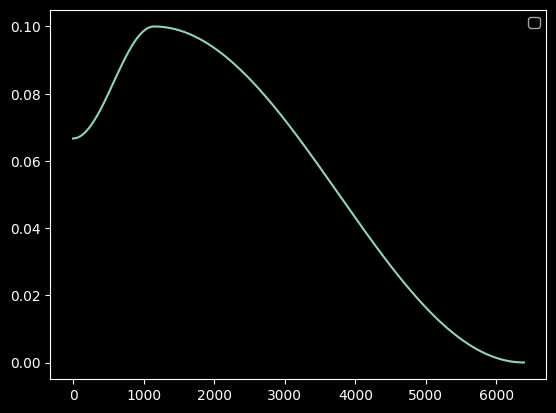

In [ ]:
from matplotlib import pyplot as plt

EPOCHS = MAX_EPOCHS
BATCHES = STEPS_PER_EPOCH
steps = []
lrs = []
mtms = []
model = ... # Your model instance
optimizer = torch.optim.SGD(fasterrcnn_model.parameters(), lr=0.1, momentum=0.9) # Wrapped optimizer
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, pct_start=0.18, div_factor=1.5, final_div_factor=10000, base_momentum=0.75, max_momentum=0.95, epochs=EPOCHS, steps_per_epoch=BATCHES)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        mtms.append(optimizer.param_groups[0]['momentum'])
        steps.append(epoch * BATCHES + batch)

plt.figure()
plt.legend()
plt.plot(steps, lrs, label='OneCycleLRs')
plt.show()

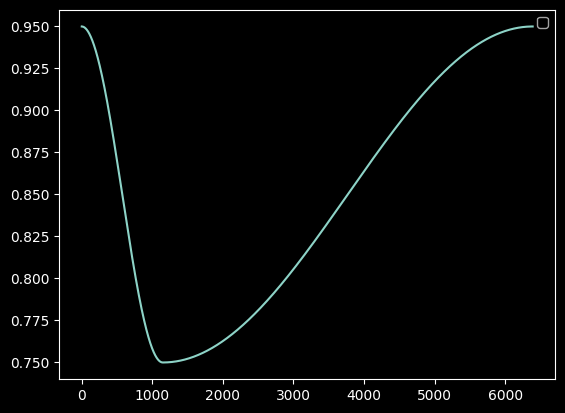

In [ ]:
plt.figure()
plt.legend()
plt.plot(steps, mtms, label='OneCycleMoments')
plt.show()

In [ ]:
np.array(lrs).max()

0.09999999750892247

In [ ]:
lrs.

SyntaxError: invalid syntax (3540091392.py, line 1)